## Model sensitivity and uncertainty analysis

This notebook demonstrates a few different ways in which the effect of model parameters on the model outcomes can be quantified using Python. It is not a formal discussion of model sensitivity and uncertainty analysis. The main aim is to demonstrate the flexibility of Python when it comes to running models mulitple times, and to show the effect on the model outcome. To this end we use the chloride mass balance model for the farm dam. Parameters that are considered to be uncertain are the pan factor, the rainfall chloride concentration and the measured rainfall, evaporation and water volume.

In [1]:
# import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

Before we can do any calculations we need to import the file with the measured data.

In [2]:

folder_path_input_data =r'D:\00_GPM\09_Tutorilas_notes\Python_Training_AWS\Inputs\data'
file_to_open = 'water_balance_data.xlsx'
path_to_open= os.path.join(folder_path_input_data,file_to_open)

df = pd.read_excel(path_to_open,index_col=0,parse_dates=True)
df.head()

,temperature,rh,rain,wl,volume,area,vpd,evaporation,Cl_sample,delta_18O_sample,delta_2H_sample
2013-08-25,11.25,81.0,0.0,-0.481333,1188.982978,1309.122275,0.253591,4.483474,20.401982,-4.32923,-16.581998
2013-08-26,10.75,89.5,0.4,-0.491695,1175.444157,1302.024401,0.135561,2.744956,NaN,NaN,NaN
2013-08-27,13.75,71.0,0.0,-0.498408,1166.708590,1297.418221,0.456128,4.896925,NaN,NaN,NaN
2013-08-28,14.00,83.0,0.0,-0.505052,1158.090844,1292.853550,0.271763,0.594952,NaN,NaN,NaN
2013-08-29,14.10,84.5,6.8,-0.505966,1156.907482,1292.225131,0.249396,2.668875,NaN,NaN,NaN


Next we will draw a number of samples from a normal distribution that respresent the uncertainty of the pan factor. The true value of the pan factor that was used to create the synthetic sample points was 1.3, which we'll use as the mean. Note that a slightly higher value was found during the calibration with `lmfit`, and that the standard error (i.e. the standard deviation) is also higher, simply because it is then easier to see the differences between the model runs.

The code below uses the `scipy.stats` module to define a normal probability distribution with a mean $\mu_p$ and a standard deviation $\sigma_p$. The value of variable `N` defines the number of values that will be used to draw the probability density function. The `norm` function is used to create the normal distribution and is stored as `dist_p`. The values for the pan factors on the x axis are defined by first calculating the value that corresponds to the 1 and 99 percent percentiles. These values are used as limits for the range of `N` x values. The probability densities for `xp` are stored in `yp` and are obtained using the `pdf` method of `dist_p`.

The pan factor that corresponds to the 1% percentile is 1.0673652125959159
The pan factor that corresponds to the 99% percentile is 1.5326347874040842


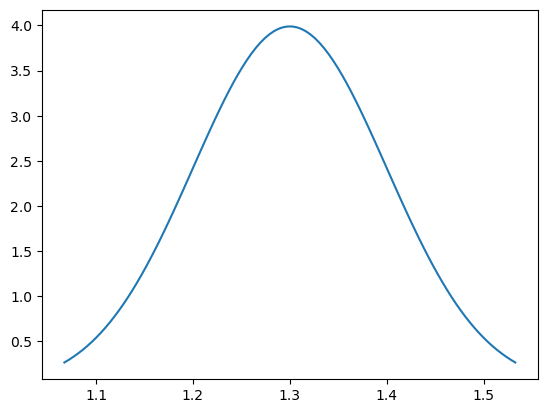

In [3]:
from scipy.stats import norm

N = 100

mu_p = 1.3
sigma_p = 0.1

dist_p = norm(loc=mu_p, scale=sigma_p)

# Get the percentile values
x001 = dist_p.ppf(0.01)
x099 = dist_p.ppf(0.99)
print(f"The pan factor that corresponds to the 1% percentile is {x001}")
print(f"The pan factor that corresponds to the 99% percentile is {x099}")

# Define the values for the x axis
xp = np.linspace(
    x001, 
    x099,
    N,
)

# Use the values in xp to get the corresponding probability densities
yp = dist_p.pdf(xp)

# Plot the probability density curve
plt.plot(xp, yp);

The `cdf` method of `dist_p` returns the cummulative probabilities and can be used to draw the cummulative probability distribution.

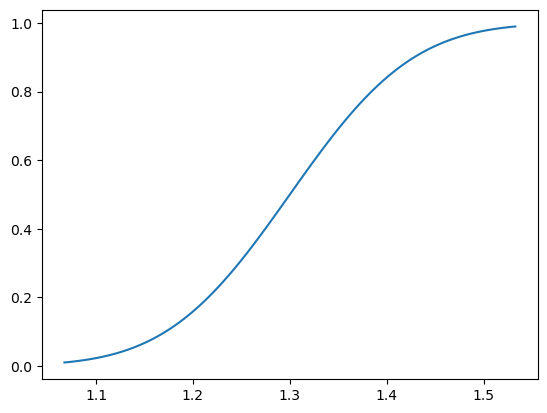

In [7]:
ypc = dist_p.cdf(xp)
plt.plot(xp, ypc);

Let's draw five pan factors from the distribution. The selected values roughly encompass the 95% and 68% confidence intervals and the median average is also included.

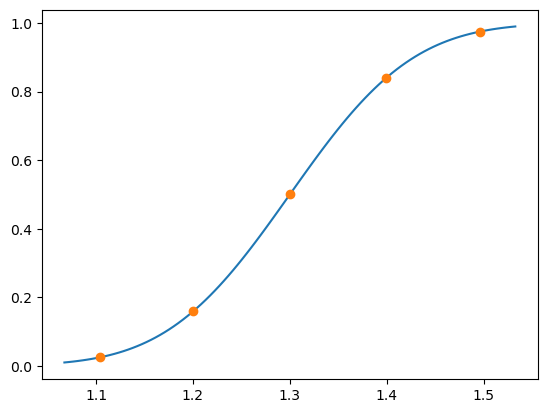

In [8]:
sample_percentiles = [0.025, 0.16, 0.5, 0.84, 0.975]
pan_factors = dist_p.ppf(sample_percentiles)
plt.plot(xp, ypc)
plt.plot(pan_factors, sample_percentiles, 'o')

The chloride mass balance is implemented as a function. Note that it takes the DataFrame `df` as an argument, which is not striclty necessary at this point, but it will be later on.

In [20]:
Cl_0 = 20 # g/m^3 = mg/l

def get_conc_cl(df, pan_factor=1.3, Cl_rain=2):
    df['P'] = df['area'] * df['rain'] / 1000.
    df['E'] = df['area'] * df['evaporation'] / (1000. * pan_factor)
    df['dV'] = -df['volume'].diff(periods=-1)
    df['I'] = df['P'] - df['E'] - df['dV']
    M_Cl_g = np.empty(len(df))
    conc_Cl = np.empty(len(df))

    P = df["P"].to_numpy()
    I = df["I"].to_numpy()
    V = df["volume"].to_numpy()
    for i, (Vi, Pi, Ii) in enumerate(zip(V, P, I)):
        if i == 0: # First day
            M_Cl_g[0] = Vi * Cl_0
            conc_Cl[0] = M_Cl_g[0] / Vi # Gives Cl_0 of course!
        else:
            M_Cl_g[i] = M_Cl_g[i - 1] + dM_P - dM_I
            conc_Cl[i] = M_Cl_g[i] / Vi

        dM_P = Cl_rain * Pi
        dM_I = conc_Cl[i] * Ii

    return conc_Cl

With the five different realizations of the pan factor, its effect on the model outcome can be visualized. All it takes is a short `for` loop that steps through the selected pan factors and calls the `get_conc` function each time, and then plots the calculated chloride concentrations as a function of time. The last line of code also draws the sample data points.

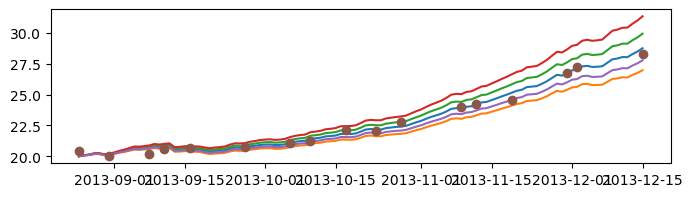

In [21]:
fig, ax = plt.subplots(figsize=(8,2))

for pan_factor in pan_factors:
    Cl = get_conc_cl(df, pan_factor=pan_factor)
    ax.plot(df.index, Cl)

plt.plot(df.index, df["Cl_sample"], 'o')

***Exercise***: Draw five values from a normal distribution of rainfall chloride concentrations (choose a mean and standard deviation that you think are reasonable).

In [ ]:
# Type your code here

Let's now run the model again, varying both the pan factor and the rainfall chloride concentration at the same time. The thing we need to remember though is that the realizations of both the pan factors and the rainfall chloride concentrations were drawn in the same order, that is the values in `pan_factors` and `Cl_rains` are both in increasing order. To fix this, we can use the `shuffle` function from `nunmpy.random`. We do this by creating an array of index values with which we can slice `pan_factors` and `Cl_rains` and use `shuffle` to put them in random order. The result is illustrate below by printing the output to the screen.

In [ ]:
indices = np.arange(len(pan_factors), dtype=int) 
print(indices)
np.random.shuffle(indices)
print(indices)

print(pan_factors)
pan_factors = pan_factors[indices]
print(pan_factors)

# Shuffle again
np.random.shuffle(indices)
print(indices)

print(Cl_rains)
Cl_rains = Cl_rains[indices]
print(Cl_rains)

Let's plot the result

In [ ]:
fig, ax = plt.subplots(figsize=(8,2))
for pan_factor, Cl_rain in zip(pan_factors, Cl_rains):
    Cl = get_conc_cl(df, pan_factor=pan_factor, Cl_rain=Cl_rain)
    ax.plot(df.index, Cl)
ax.plot(df.index, df["Cl_sample"], 'o')

The final example also takes into consideration the uncertainty of the rainfall measurements. Note how a ~10% random error (assumed to be normally distributed) is added to each value in the `rain` column of `df`. The 10% is approximate, it is the result of using a standard deviation of 0.033 for the normal distribution (with about 99.7% of values being within three standard deviations from the mean).

In [ ]:
Cl_0 = 20 # g/m^3 = mg/l

def get_conc_cl(df, pan_factor=1.3, Cl_rain=2, sd1=0.033):
    e_rain = np.random.normal(0, sd1, len(df['rain'])) * df['rain']
    df['rain'] = df['rain'] + e_rain
    df['evaporation'] = df['evaporation'] 
    df['volume'] = df['volume'] 
    df['P'] = df['area'] * df['rain'] / 1000.
    df['E'] = df['area'] * df['evaporation'] / (1000. * pan_factor)
    df['dV'] = -df['volume'].diff(periods=-1)
    df['I'] = df['P'] - df['E'] - df['dV']
    M_Cl_g = np.empty(len(df))
    conc_Cl = np.empty(len(df))

    P = df["P"].to_numpy()
    I = df["I"].to_numpy()
    V = df["volume"].to_numpy()
    for i, (Vi, Pi, Ii) in enumerate(zip(V, P, I)):
        if i == 0: # First day
            M_Cl_g[0] = Vi * Cl_0
            conc_Cl[0] = M_Cl_g[0] / Vi # Gives Cl_0 of course!
        else:
            M_Cl_g[i] = M_Cl_g[i - 1] + dM_P - dM_I
            conc_Cl[i] = M_Cl_g[i] / Vi

        dM_P = Cl_rain * Pi
        dM_I = conc_Cl[i] * Ii

    return conc_Cl

Because our model runs very fast we can easily run it 100 times. The lines plot close to one another, which resembles an uncertainty band. In the next session we'll look into how we can improve the appearance of graphs like this one.

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
for n in range(100):
    Cl = get_conc_cl(df.copy(), sd1=0.033)
    ax.plot(df.index, Cl)
ax.plot(df.index, df["Cl_sample"], 'o')

***Exercise (homework)***: Use the code examples above to create a series of 100 model runs in which the pan factor, rainfall chloride concentration as well as the measured rainfall, evaporation and the dam water volume are all stochastic parameters.